# Importing libraries and data

---



In [ ]:
import os
from pathlib import Path
import glob

import numpy as np
import pandas as pd 
import cv2 as cv

from sklearn.metrics import mean_squared_error
from math import sqrt

!pip install sewar
from sewar.full_ref import uqi, psnr, rmse, ssim

import matplotlib.pyplot as plt
import matplotlib.image as image
from skimage.io import imread, imshow, imsave
from keras.utils.image_utils import load_img, array_to_img, img_to_array
from keras.models import Sequential,load_model, Model
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input,Dropout, BatchNormalization,LeakyReLU
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)
from google.colab import drive 
drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
input_dir  = Path('/content/gdrive/My Drive/IPML/dataset/')
train = input_dir / 'train'
train_cleaned = input_dir / 'train_cleaned'
test = input_dir / 'test'

In [ ]:
train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))

print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


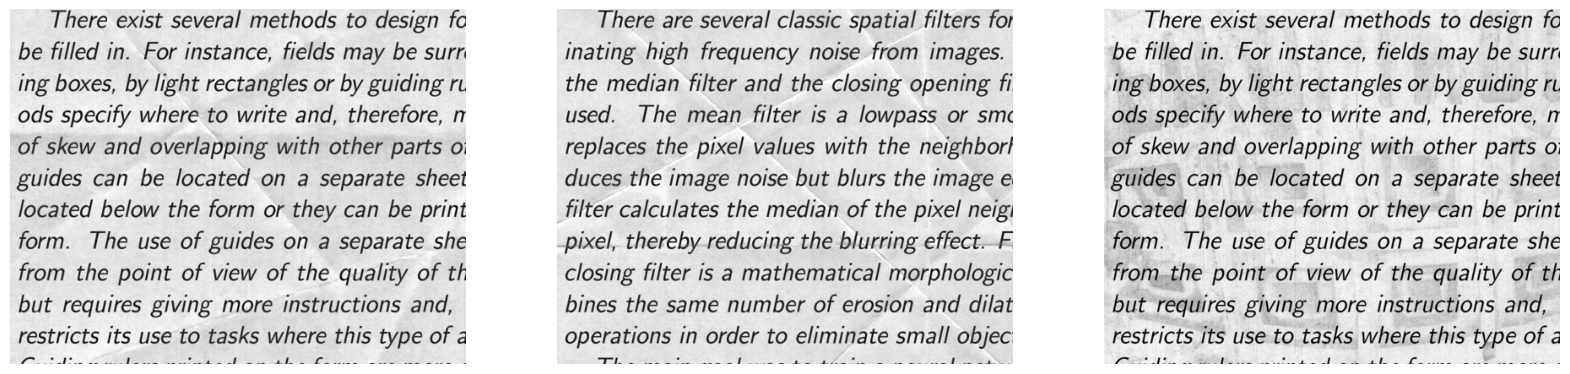

In [ ]:
samples = train_images[:3]

f, ax = plt.subplots(1, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img = imread(train/img)
    ax[i%3].imshow(img, cmap='gray')
    ax[i%3].axis('off')
plt.show()   

In [ ]:
X = []
Y = []

for img in train_images:
    img = load_img(train / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


# Training the model

---



In [ ]:
def build_autoencoder():
    input_img = Input(shape=(420,540,1), name='image_input')

    # encoding
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.3)(x)

    # decoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Model
    autoencoder = Model(inputs=input_img, outputs=output_layer)
    
    optimizer = Adam(learning_rate=9e-4, decay=1e-5)
    autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    autoencoder.summary()
    
    return autoencoder

In [ ]:
autoencoder = build_autoencoder()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 420, 540, 32)      320       
                                                                 
 conv2d_16 (Conv2D)          (None, 420, 540, 64)      18496     
                                                                 
 batch_normalization_6 (Batc  (None, 420, 540, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 210, 270, 64)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 210, 270, 64)      0   

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.15, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (122, 420, 540, 1)
Total number of validation samples:  (22, 420, 540, 1)


In [ ]:
callback = EarlyStopping(monitor='loss', patience=30)

autoencoder.fit(X_train, y_train, epochs=200, batch_size=16,callbacks=[callback], validation_data=(X_valid, y_valid))
# autoencoder.save('/content/gdrive/My Drive/IPML/model.h5')


Epoch 1/200
8/8 [==============================] - 6s 617ms/step - loss: 0.1592 - mae: 0.3285 - val_loss: 0.1997 - val_mae: 0.4341
Epoch 2/200
8/8 [==============================] - 5s 594ms/step - loss: 0.0877 - mae: 0.2281 - val_loss: 0.1662 - val_mae: 0.3966
Epoch 3/200
8/8 [==============================] - 5s 595ms/step - loss: 0.0651 - mae: 0.1962 - val_loss: 0.1348 - val_mae: 0.3557
Epoch 4/200
8/8 [==============================] - 5s 594ms/step - loss: 0.0525 - mae: 0.1709 - val_loss: 0.1105 - val_mae: 0.3173
Epoch 5/200
8/8 [==============================] - 5s 596ms/step - loss: 0.0438 - mae: 0.1527 - val_loss: 0.0932 - val_mae: 0.2828
Epoch 6/200
8/8 [==============================] - 5s 600ms/step - loss: 0.0376 - mae: 0.1386 - val_loss: 0.0828 - val_mae: 0.2564
Epoch 7/200
8/8 [==============================] - 5s 598ms/step - loss: 0.0330 - mae: 0.1282 - val_loss: 0.0763 - val_mae: 0.2353
Epoch 8/200
8/8 [==============================] - 5s 601ms/step - loss: 0.0294 - m

In [ ]:
autoencoder.save('/content/gdrive/My Drive/IPML/model.h5')

# Testing the model

----




In [ ]:
model = load_model('/content/gdrive/My Drive/IPML/model.h5')

99.png


/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 8s 8s/step


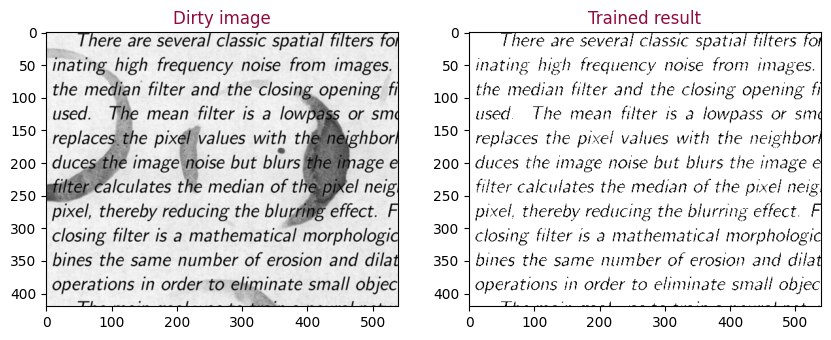

In [ ]:
print(train_images[-1])
sample_test = load_img(train/ train_images[-1], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(model.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')

ax[0].set_title('Dirty image', color='#900c3f')
ax[1].set_title('Trained result', color='#900c3f')

plt.show()

In [ ]:
print(train_images[-1])
sample_test = np.squeeze(sample_test)
sample_cleaned_test=load_img(train_cleaned/ train_images[-1], color_mode="grayscale", target_size=(420,540))
sample_cleaned_test = img_to_array(sample_cleaned_test)
sample_cleaned_test = np.squeeze(sample_cleaned_test)
print("RMSE:", rmse(sample_cleaned_test, predicted_label))
print("UQI:", uqi(sample_cleaned_test, predicted_label))
print("PSNR:", cv.PSNR(sample_cleaned_test, predicted_label))

99.png
RMSE: 234.29329228892595
UQI: 6.409372042232248e-05
PSNR: 0.7356065062751369


97.png
1/1 [==============================] - 0s 23ms/step


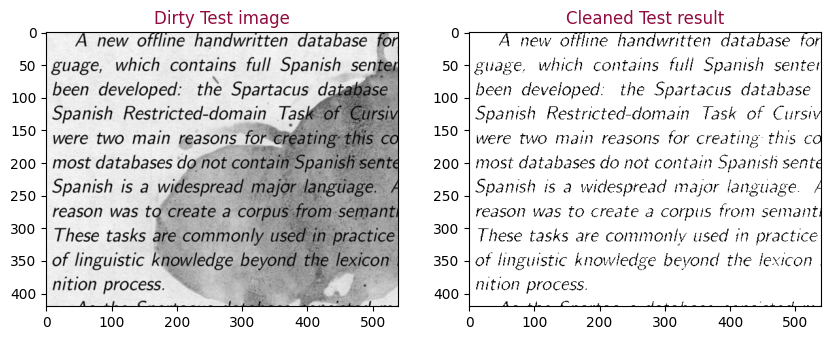

In [ ]:
sample_test = load_img(test/ test_images[-1], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

print(test_images[-1])

# Get the predition
predicted_label = np.squeeze(model.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')

ax[0].set_title('Dirty Test image', color='#900c3f')
ax[1].set_title('Cleaned Test result', color='#900c3f')

plt.show()

# Testing with live data

---



In [ ]:
model = load_model('/content/gdrive/My Drive/IPML/model.h5')

In [ ]:
l_org = load_img('/content/gdrive/My Drive/IPML/denoise_test.png',target_size=(420,540))
l_org_gray = load_img('/content/gdrive/My Drive/IPML/denoise_test.png', grayscale=True,target_size=(420,540))
l_test = img_to_array(l_org_gray).astype('float32')/255.
l_test = np.expand_dims(l_test, axis=0)

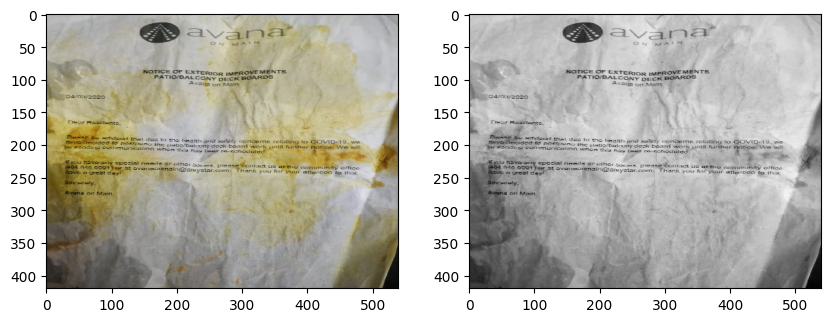

In [ ]:
f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(l_org)
ax[1].imshow(l_org_gray, cmap='gray')

1/1 [==============================] - 0s 130ms/step


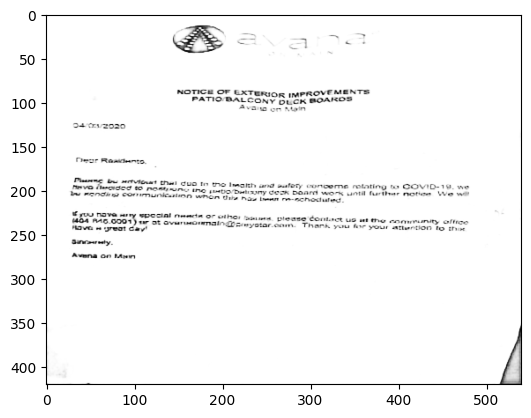

In [ ]:
cleaned = np.squeeze(model.predict(l_test))
plt.imshow(cleaned, cmap='gray')